## Financial Data Analysis


#### IMPORTING IMPORTANT LIBRARIES


In [1]:
import datetime

import pandas as pd
import numpy as np


import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import nltk
import textblob
import talib as ta

In [2]:
import sys
import os


sys.path.append(os.path.abspath("../scripts"))
from utils import *
from language_processing import *

data_utils = DataUtils()
LangProcess = LanguageProcessing()

### EXPLORATORY DATA ANALYSIS

#### IMPORTING DATASET

In [3]:
news = data_utils.load_news_data()

In [12]:
news.head()

,headline,url,publisher,stock
date,,,,
2020-06-05 14:30:54+00:00,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A
2020-06-03 14:45:20+00:00,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A
2020-05-26 08:30:07+00:00,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A
2020-05-22 16:45:06+00:00,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A
2020-05-22 15:38:59+00:00,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A


In [5]:
news.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1407328 entries, 2020-06-05 14:30:54+00:00 to 2011-05-12 04:00:00+00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   stock      1407328 non-null  object
dtypes: object(4)
memory usage: 53.7+ MB


In [6]:
news.shape

(1407328, 4)

In [7]:
news.isnull().sum()

headline     0
url          0
publisher    0
stock        0
dtype: int64

In [4]:
news[news.duplicated()]

,headline,url,publisher,stock
date,,,,
2015-07-07 04:00:00+00:00,API Tech Reports Q2 Loss $0.08 Vs Exp Loss $0....,https://www.benzinga.com/news/earnings/15/07/5...,Eddie Staley,ATNY
2015-07-01 04:00:00+00:00,"Top Performing Industries For July 1, 2015",https://www.benzinga.com/news/15/07/5642290/to...,Lisa Levin,GME


**Observation**
- The data doesn't contain null or duplicated values.

### Descriptive Statistics

In [5]:
news["headline length"] = news["headline"].apply(lambda x: len(x.split()))

In [6]:
news.describe()

,headline length
count,1.407328e+06
mean,1.141671e+01
std,6.352997e+00
min,1.000000e+00
25%,7.000000e+00
50%,1.000000e+01
75%,1.300000e+01
max,7.700000e+01


In [14]:
news_publishers = (
    news.groupby(by=["publisher"])["headline"].count().sort_values(ascending=False)
)

##### Top 10 publishers

In [17]:
px.bar(news_publishers.head(10), labels={"value": "Number of news published"})

In [16]:
px.line(
    news.resample("ME").size(),
    title="Publicaitons per month",
    labels={"date": "Months", "value": "Number of news published"},
)

**Observation**
- From the figure we can clearly see a spike in number of news published after december 2019 this might be due to corona virus.

In [19]:
px.line(
    news.groupby([news.index.year])["headline"].count(),
    labels={"value": "Number of news published", "date": "Year"},
)

**Observation**
- After 2011, the number of news coverage was almost the same throughout the decade. And the number of news published reached its peak in 2019, this might be due to corona virus.

In [20]:
px.line(
    news.groupby([news.index.day])["headline"].count(),
    labels={"value": "Number of news published", "date": "Dates"},
)

**Observation**
- Around the seventh or eighth day of the month, we see a slight spike, but the news coverage throughout the month is generally the same. The dip we see on the 31st day is because few months of the year have 31 days.

### Text Analysis

#### Sentiment analysis

In [7]:
news["cleaned_headline"] = news["headline"].apply(
    lambda word: LangProcess.clean_data(word)
)

In [8]:
news["cleaned_headline"].isnull().sum()

0

In [9]:
news.dropna(inplace=True)

In [10]:
news["sentiment"] = news["cleaned_headline"].apply(
    lambda word: LangProcess.sentiment_analysis(word)
)

In [11]:
news["sentiment_category"] = news["sentiment"].apply(
    lambda x: LangProcess.categorize_headline(x)
)
px.bar(news["sentiment_category"].value_counts())

In [12]:
news["sentiment_category"].value_counts()

sentiment_category
Neutral               1245397
Positive               114562
Negative                45098
Extremely Positive       2050
Extremely Negative        221
Name: count, dtype: int64

In [11]:
news.to_csv("News Sentiment.csv")

#### Topic modelling

In [6]:
# The top 10 Topics/words that appear
word_count = LangProcess.TopicModel_TFIDF(news)
word_count.head(10)

stocks       60710.800891
market       50704.430556
reports      46649.321116
vs           46586.273132
shares       45817.598239
earnings     44637.051339
benzinga     42176.824784
update       41801.632940
est          41141.876663
announces    38309.220465
dtype: float64

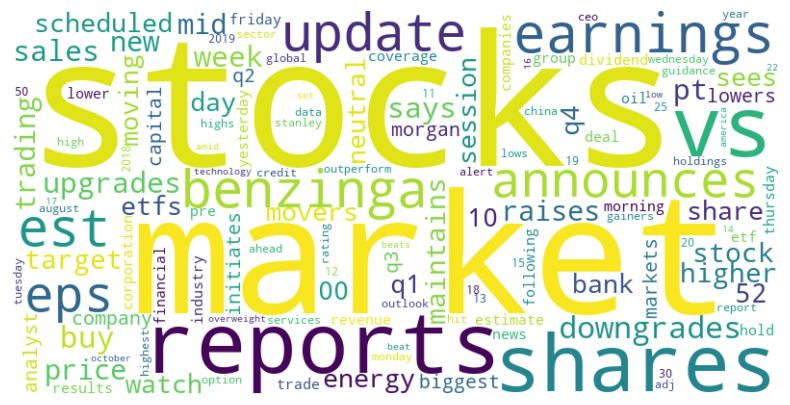

In [7]:
# Word Cloud for news headline
LangProcess.plot_wordCloud(word_count)

### TimeSeries analysis

In [4]:
from TimeSeries import *

TSA = TimeAnalysis(news)

time_series_daily, time_series_monthly, time_series_yearly = TSA.date_prep()

##### Yearly analysis

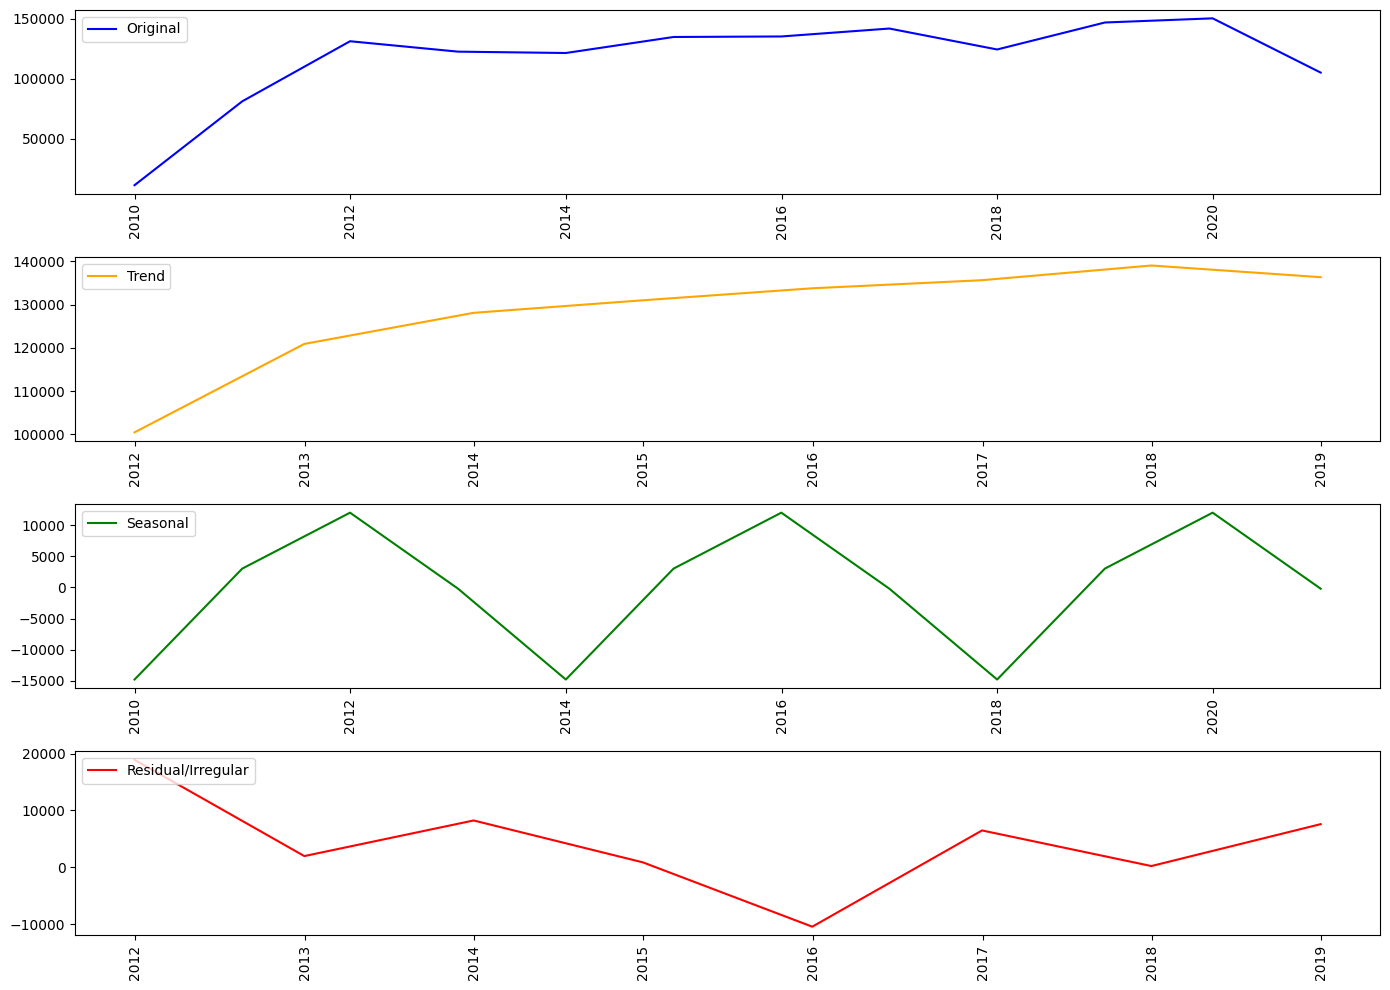

In [5]:
TSA.time_decompose(time_series_yearly, 4)

##### Monthly analysis

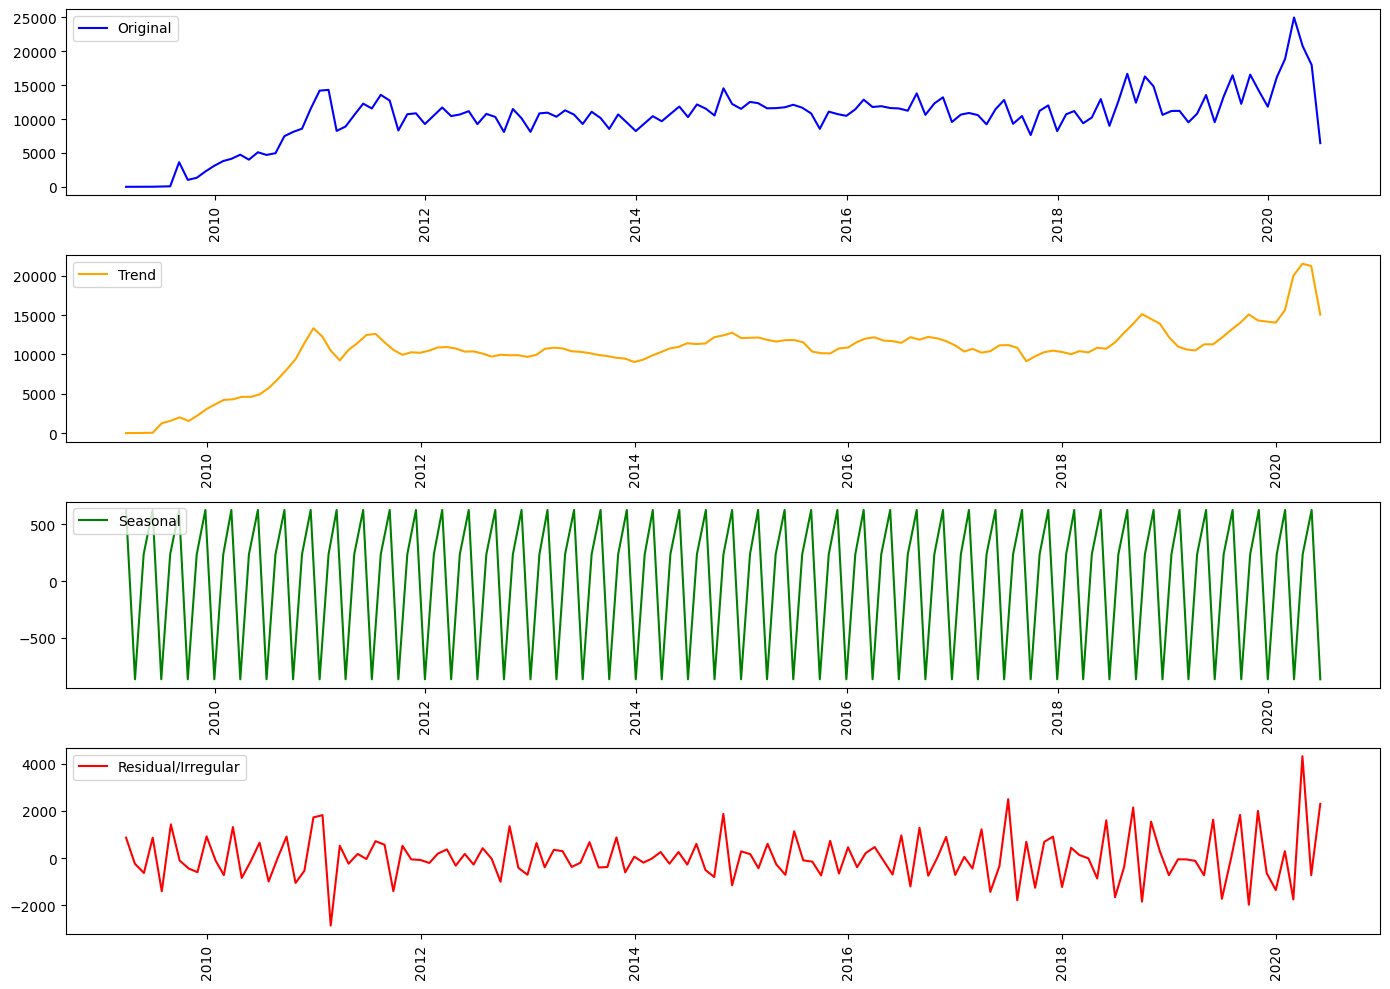

In [6]:
TSA.time_decompose(time_series_monthly, 3)

In [7]:
TSA.decompose_season(time_series_monthly, 3)

**Observation**
- By zooming in to the monthly seasonality data, we can see that there is a spike in news published every couple of months, and the months are:
    * February
    * May
    * August
    * November
- This pattern could be related to specific financial events, such as quarterly earnings reports, which often occur around these months. 

##### Daily analysis

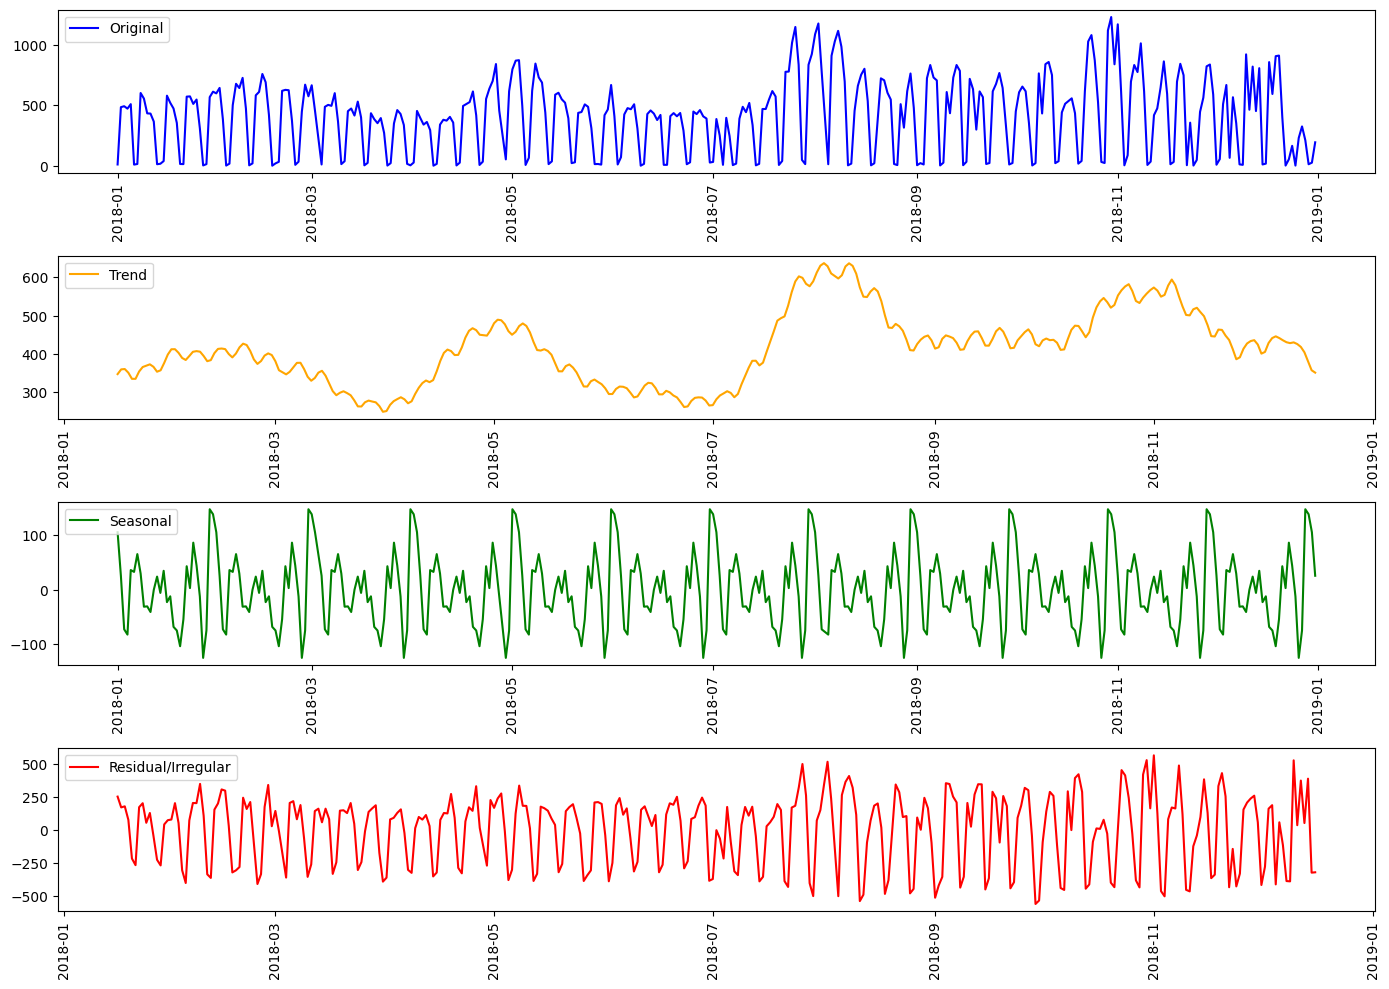

In [12]:
TSA.time_decompose(time_series_daily, 30, True)

In [15]:
TSA.decompose_season(time_series_daily, 30, True)

**Observation**
- By zooming in to the monthly seasonality data, we can see that there is a spike in news published at the end of every months, and the months and dates are:
    * Jan 29      
    * Feb 28
    * Mar 31
    * May 31
    * Jun 30
    * Jul 31
    * Aug 30
    * Sep 29
    * Oct 29
    * Nov 29
    * Dec 29
- This pattern could be related to specific financial events, such as End-of-Month Reporting, Portfolio Rebalancing, Monthly Market Summary Articles etc.

##### **Publishing times**

In [22]:
news.index = pd.to_datetime(news.index)
news.index = news.index.tz_localize(None)

In [33]:
# Most published news based on hourly analysis
news.groupby(by=news.index.hour).size().sort_values(ascending=False).head(8)

date
4     1351408
14       7669
13       5965
16       5732
15       5701
12       5527
11       5033
20       3939
dtype: int64

In [34]:
# Most published news based on minutes analysis
news.groupby(by=news.index.minute).size().sort_values(ascending=False).head(8)

date
0     1352404
10       1727
16       1416
1        1270
22       1219
30       1184
34       1176
33       1166
dtype: int64

**Observation**
- most of the news are relesed on 4:00 and 14:00 and other major times are 13:00, 16:00, 15:00, 12:00, 11:00. 